In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from datetime import datetime
import matplotlib.pyplot as plt
from seaborn import heatmap

from ta import trend as t
from ta import volatility as v
from ta import momentum as m

In [2]:
FILE_PATH = "./CQF_use.csv"

In [3]:
cols_id = ["stockname", "dt"]
col_target_up = "target_up"
col_target_down = "target_down"

In [4]:
data = pd.read_csv(FILE_PATH)
data = data.iloc[:, 1:]

In [5]:
display(data.head(3))
display(data.columns)

,id,dt,stockname,Open,High,Low,Close,Volume,Dividends,Stock_splits
0,c93aaf8dfd61957c30d7ea675dcec521,2018-07-02,NVDA,232.435339,240.676674,231.611204,240.527740,8939300.0,0.0,0.0
1,424511bb3602e72f81b1cf6f15054bfc,2018-07-03,NVDA,241.917878,242.156187,234.828346,235.165939,5568300.0,0.0,0.0
2,bebef7767033f8330392dbb3a29e4108,2018-07-05,NVDA,237.380179,241.212881,235.821269,241.014297,7655400.0,0.0,0.0


Index(['id', 'dt', 'stockname', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock_splits'],
      dtype='object')

In [6]:
dl = []
for i in ["NVDA", "AAPL", "CSCO", "INTC"]:
    dl.append(data[data["stockname"] == i])
data = pd.concat(dl)
display(data.head())

,id,dt,stockname,Open,High,Low,Close,Volume,Dividends,Stock_splits
0,c93aaf8dfd61957c30d7ea675dcec521,2018-07-02,NVDA,232.435339,240.676674,231.611204,240.527740,8939300.0,0.0,0.0
1,424511bb3602e72f81b1cf6f15054bfc,2018-07-03,NVDA,241.917878,242.156187,234.828346,235.165939,5568300.0,0.0,0.0
2,bebef7767033f8330392dbb3a29e4108,2018-07-05,NVDA,237.380179,241.212881,235.821269,241.014297,7655400.0,0.0,0.0
3,c385adb8cdd340196a307ef9f2036b38,2018-07-06,NVDA,240.031288,245.919365,239.177366,245.581772,7408800.0,0.0,0.0
4,c51d13354b446f603a378e98f9acf6a0,2018-07-09,NVDA,248.560573,248.947816,244.330690,247.488205,7597000.0,0.0,0.0


# Feature Engineering

### Sign - Target variable

In [7]:
# cols_raw.append(col_target_up)
def fe_add_sign(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Form the sign for ups and downs.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["Close"]].sort_values(by="dt")
    df["return"] = df.loc[:, "Close"].pct_change()
    df.loc[:, col_target_up], df.loc[:, col_target_down] = df.loc[:, "Close"].pct_change(), df.loc[:, "Close"].pct_change()
    df.loc[(df[col_target_up] > 0.01), col_target_up] = 1
    df.loc[(df[col_target_up] <= 0.01), col_target_up] = 0
    df.loc[(df[col_target_down] >= -0.01), col_target_down] = 0
    df.loc[(df[col_target_down] < -0.01), col_target_down] = 1
    df[col_target_up] = df[col_target_up].shift(-1)
    df[col_target_down] = df[col_target_down].shift(-1)
    return df[cols_index + [col_target_up, col_target_down]]

### Past returns

In [8]:
def fe_add_past_returns(raw_data: pd.DataFrame, stock_name: str, cols_index: list, lag: int):
    """
    Generate past return variable.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["Close"]].sort_values(by="dt")
    df["return_{}".format(lag)] = df["Close"].pct_change().shift(lag - 1)
    return df[cols_index + ["return_{}".format(lag)]]

### Momentum

In [9]:
def fe_add_momentum(raw_data: pd.DataFrame, stock_name: str, cols_index: list, lag: int):
    """
    Generate momentum, which is the price change period k days.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["Close"]].sort_values(by="dt")
    df["momentum_{}".format(lag)] = (df["Close"] - df["Close"].shift(lag)) / df["Close"].shift(lag)
    return df[cols_index + ["momentum_{}".format(lag)]]

### Moving Average

In [10]:
def fe_add_ema(raw_data: pd.DataFrame, stock_name: str, cols_index: list, window_sizes: list):
    """
    Generate moving average.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["Close"]].sort_values(by="dt")
    cols_new = []
    for window_size in window_sizes:
        df["EMA_{}".format(window_size)] = t.ema_indicator(df["Close"], window_size + 1)
        cols_new.append("EMA_{}".format(window_size))
    return df[cols_index + cols_new]

### Open-Close, High-Low

In [11]:
def fe_add_oc_hl(raw_data: pd.DataFrame, cols_index: list):
    """
    Generate differences between open and close, high and low.
    """
    df = raw_data.loc[:, cols_index + ["Open", "High", "Low", "Close"]]
    df["OC"] = df["Open"] - df["Close"]
    df["HL"] = df["High"] - df["Low"]
    return df[cols_index + ["OC", "HL"]]

### KST

In [12]:
def fe_add_kst(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Generate KST indicator.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["Close"]].sort_values(by="dt")
    df["KST"] = t.KSTIndicator(df["Close"]).kst()
    return df[cols_index + ["KST"]]

### VortexIndicator

In [13]:
def fe_add_vi(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Generate Vortex Indicator.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["High", "Low", "Close"]].sort_values(by="dt")
    df["VI"] = t.VortexIndicator(df["High"], df["Low"], df["Close"]).vortex_indicator_diff()
    return df[cols_index + ["VI"]]

### Parabolic Stop and Reverse Trend

In [14]:
def fe_add_psar(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Generate Parabolic stop and reverse trend: up & down.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["High", "Low", "Close"]].sort_values(by="dt")
    df["PSRT_up"] = t.psar_up_indicator(df["High"], df["Low"], df["Close"])
    df["PSRT_down"] = t.psar_down_indicator(df["High"], df["Low"], df["Close"])
    return df[cols_index + ["PSRT_up", "PSRT_down"]]

### RSI

In [15]:
def fe_add_rsi(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Generate RSI indicator.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["High", "Low", "Close"]].sort_values(by="dt")
    df["RSI"] = rsi(df["Close"])
    return df[cols_index + ["RSI"]]

### TSI

In [16]:
def fe_add_tsi(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Generate TSI indicator.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["Close"]].sort_values(by="dt")
    df["TSI"] = m.tsi(df["Close"])
    return df[cols_index + ["TSI"]]

### SMA of Stochastic Oscillator

In [17]:
def fe_add_stoch_signal(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Generate Stochastic Oscillator Signal.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["High", "Low", "Close"]].sort_values(by="dt")
    df["stoch_signal"] = m.stoch_signal(df["High"], df["Low"], df["Close"])
    return df[cols_index + ["stoch_signal"]]

### average_true_range

In [18]:
def fe_add_average_true_range(raw_data: pd.DataFrame, stock_name: str, cols_index: list):
    """
    Generate Average True Range indicator.
    """
    df = raw_data.loc[(raw_data["stockname"] == stock_name), cols_index + ["High", "Low", "Close"]].sort_values(by="dt")
    df["ATR"] = v.average_true_range(df["High"], df["Low"], df["Close"])
    return df[cols_index + ["ATR"]]

# Generate Signals

In [19]:
df_list = []
for stock in data["stockname"].unique():
    print(stock)
    sub_df = data.loc[(data["stockname"] == stock)]
    sub_df = pd.merge(sub_df, fe_add_sign(data, stock, cols_id), on=cols_id, how="left")
    df_list.append(sub_df)
data = pd.concat(df_list).dropna()
display(data.head())

NVDA
AAPL
CSCO
INTC


,id,dt,stockname,Open,High,Low,Close,Volume,Dividends,Stock_splits,target_up,target_down
0,c93aaf8dfd61957c30d7ea675dcec521,2018-07-02,NVDA,232.435339,240.676674,231.611204,240.527740,8939300.0,0.0,0.0,0.0,1.0
1,424511bb3602e72f81b1cf6f15054bfc,2018-07-03,NVDA,241.917878,242.156187,234.828346,235.165939,5568300.0,0.0,0.0,1.0,0.0
2,bebef7767033f8330392dbb3a29e4108,2018-07-05,NVDA,237.380179,241.212881,235.821269,241.014297,7655400.0,0.0,0.0,1.0,0.0
3,c385adb8cdd340196a307ef9f2036b38,2018-07-06,NVDA,240.031288,245.919365,239.177366,245.581772,7408800.0,0.0,0.0,0.0,0.0
4,c51d13354b446f603a378e98f9acf6a0,2018-07-09,NVDA,248.560573,248.947816,244.330690,247.488205,7597000.0,0.0,0.0,1.0,0.0


## Examine Some parameters

### Past Returns

In [20]:
for lag in range(10):
    print(lag + 1)
    test_data = []
    for stock in data.stockname.unique():
        sub_data = data.loc[(data["stockname"] == stock), cols_id + [col_target_up, col_target_down]]
        sub_data = pd.merge(sub_data, fe_add_past_returns(data, stock, cols_id, lag + 1), on=cols_id, how="left")
        test_data.append(sub_data)
    test_data = pd.concat(test_data).dropna()
    
    x, y1 = test_data["return_{}".format(lag + 1)], test_data[col_target_up]
    lr = Logit(y1, x)
    res = lr.fit()
    print("===== Up Trend =====")
    print(res.summary2())
    
    x, y2 = test_data["return_{}".format(lag + 1)], test_data[col_target_down]
    lr = Logit(y2, x)
    res = lr.fit()
    print("===== Down Trend =====")
    print(res.summary2())
    print("")

1
Optimization terminated successfully.
         Current function value: 0.687239
         Iterations 5
===== Up Trend =====
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.121   
Dependent Variable: target_up        AIC:              4020.9758
Date:               2021-12-29 14:41 BIC:              4026.9565
No. Observations:   2924             Log-Likelihood:   -2009.5  
Df Model:           0                LL-Null:          -1792.7  
Df Residuals:       2923             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025    0.975]
-----------------------------------------------------------------
return_1    -8.6521    1.5422  -5.6101  0.0000  -11.6748  -5.6294

Optimization terminated successfully.
         Cur

Optimization terminated successfully.
         Current function value: 0.692551
         Iterations 5
===== Up Trend =====
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.130   
Dependent Variable: target_up        AIC:              4024.3361
Date:               2021-12-29 14:41 BIC:              4030.3100
No. Observations:   2904             Log-Likelihood:   -2011.2  
Df Model:           0                LL-Null:          -1779.7  
Df Residuals:       2903             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-----------------------------------------------------------------
return_6      -2.4765    1.3731  -1.8036  0.0713  -5.1677  0.2146

Optimization terminated successfully.
         Curre

- The significance of past return from lag 1 to lag 10 differes a lot. Either the positive target or negative target is statistically significant. Hence, I only exclude the predictors with that are not statistically significant in neither targets for the past return.
    - return_1
    - return_2
    - return_5
    - return_6
    - return_7
    - return_8
    - return_9
    - return_10

### Momentum

In [21]:
for lag in range(10):
    print(lag + 1)
    test_data = []
    for stock in data.stockname.unique():
        sub_data = data.loc[(data["stockname"] == stock), cols_id + [col_target_up, col_target_down]]
        sub_data = pd.merge(sub_data, fe_add_momentum(data, stock, cols_id, lag + 1), on=cols_id, how="left")
        test_data.append(sub_data)
    test_data = pd.concat(test_data).dropna()
    
    x, y1 = test_data["momentum_{}".format(lag + 1)], test_data[col_target_up]
    lr = Logit(y1, x)
    res = lr.fit()
    print("===== Up Trend =====")
    print(res.summary2())
    
    x, y2 = test_data["momentum_{}".format(lag + 1)], test_data[col_target_down]
    lr = Logit(y2, x)
    res = lr.fit()
    print("===== Down Trend =====")
    print(res.summary2())
    print("")

1
Optimization terminated successfully.
         Current function value: 0.687239
         Iterations 5
===== Up Trend =====
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.121   
Dependent Variable: target_up        AIC:              4020.9758
Date:               2021-12-29 14:41 BIC:              4026.9565
No. Observations:   2924             Log-Likelihood:   -2009.5  
Df Model:           0                LL-Null:          -1792.7  
Df Residuals:       2923             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025    0.975]
-----------------------------------------------------------------
momentum_1  -8.6521    1.5422  -5.6101  0.0000  -11.6748  -5.6294

Optimization terminated successfully.
         Cur

Optimization terminated successfully.
         Current function value: 0.690204
         Iterations 5
===== Up Trend =====
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.126   
Dependent Variable: target_up        AIC:              4010.7064
Date:               2021-12-29 14:41 BIC:              4016.6802
No. Observations:   2904             Log-Likelihood:   -2004.4  
Df Model:           0                LL-Null:          -1779.7  
Df Residuals:       2903             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
momentum_6   -2.4581    0.6196  -3.9670  0.0001  -3.6726  -1.2436

Optimization terminated successfully.
         Curre

Optimization terminated successfully.
         Current function value: 0.690169
         Iterations 4
===== Up Trend =====
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.127   
Dependent Variable: target_up        AIC:              3988.4145
Date:               2021-12-29 14:41 BIC:              3994.3828
No. Observations:   2888             Log-Likelihood:   -1993.2  
Df Model:           0                LL-Null:          -1768.9  
Df Residuals:       2887             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
momentum_10  -1.8938    0.4709  -4.0219  0.0001  -2.8167  -0.9709

Optimization terminated successfully.
         Curre

- The momentum predictors show significance in both targets after 5 days' lag. As a result, I included most of the momentum predictors with not less than 5 days' lag.
    - momentum_5
    - momentum_7
    - momentum_8
    - momentum_9
    - momentum_10

#### <font color="cornflowerblue">Use 50-day price momentum to predict the target</font>

In [22]:
test_data = []
for stock in data.stockname.unique():
    sub_data = data.loc[(data["stockname"] == stock), cols_id + [col_target_up, col_target_down]]
    sub_data = pd.merge(sub_data, fe_add_momentum(data, stock, cols_id, 50 + 1), on=cols_id, how="left")
    test_data.append(sub_data)
test_data = pd.concat(test_data).dropna()

x, y1 = test_data["momentum_{}".format(50 + 1)], test_data[col_target_up]
lr = Logit(y1, x)
res = lr.fit()
print("===== Up Trend =====")
print(res.summary2())

x, y2 = test_data["momentum_{}".format(50 + 1)], test_data[col_target_down]
lr = Logit(y2, x)
res = lr.fit()
print("===== Down Trend =====")
print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.683304
         Iterations 4
===== Up Trend =====
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.109   
Dependent Variable: target_up        AIC:              3724.6382
Date:               2021-12-29 14:41 BIC:              3730.5481
No. Observations:   2724             Log-Likelihood:   -1861.3  
Df Model:           0                LL-Null:          -1678.8  
Df Residuals:       2723             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
momentum_51  -1.5249    0.2124  -7.1790  0.0000  -1.9412  -1.1086

Optimization terminated successfully.
         Curre

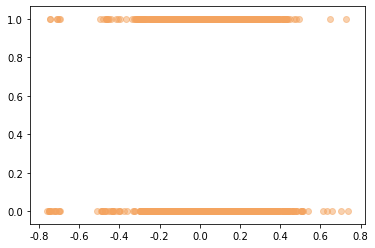

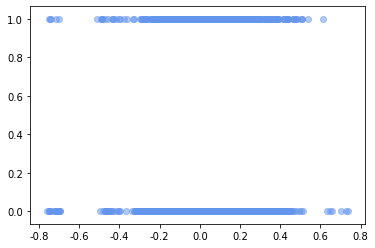

In [23]:
plt.scatter(x, y1, color="sandybrown", alpha=0.5)
plt.show()
plt.scatter(x, y2, color="cornflowerblue", alpha=0.5)
plt.show()

<font color="cornflowerblue">Yes, it makes sense to use 50-day momentum variable in prediction. For 50-day momentum variable, it is statistically significant. Though it has no significant relationship between dependent and explained variables. But most of the predictors in trading do not have significant relationship.</font>

### EMA

In [24]:
test_data = []
for stock in data.stockname.unique():
    sub_data = data.loc[(data["stockname"] == stock), cols_id + [col_target_up, col_target_down]]
    sub_data = pd.merge(sub_data, fe_add_ema(data, stock, cols_id, [3, 5, 10, 14, 20]), on=cols_id, how="left")
    test_data.append(sub_data)
test_data = pd.concat(test_data).dropna()
cols_ema = ["EMA_3", "EMA_5", "EMA_10", "EMA_14", "EMA_20"]

scaler = StandardScaler()
test_data[cols_ema] = scaler.fit_transform(test_data[cols_ema])

for col in cols_ema:
    x, y1 = test_data[col], test_data[col_target_up]
    lr = Logit(y1, x)
    res = lr.fit()
    print("===== Up Trend =====")
    print(res.summary2())

    x, y2 = test_data[col], test_data[col_target_down]
    lr = Logit(y2, x)
    res = lr.fit()
    print("===== Down Trend =====")
    print(res.summary2())
    print("")

Optimization terminated successfully.
         Current function value: 0.691035
         Iterations 4
===== Up Trend =====
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.123   
Dependent Variable: target_up        AIC:              3938.1373
Date:               2021-12-29 14:41 BIC:              3944.0917
No. Observations:   2848             Log-Likelihood:   -1968.1  
Df Model:           0                LL-Null:          -1751.9  
Df Residuals:       2847             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-------------------------------------------------------------------
         Coef.     Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
EMA_3    0.1310      0.0380    3.4423    0.0006    0.0564    0.2055

Optimization terminated successfully.
      

                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.247   
Dependent Variable: target_down      AIC:              3940.9806
Date:               2021-12-29 14:41 BIC:              3946.9350
No. Observations:   2848             Log-Likelihood:   -1969.5  
Df Model:           0                LL-Null:          -1579.2  
Df Residuals:       2847             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
EMA_20       0.1142     0.0379   3.0140   0.0026   0.0399   0.1885




- The result shows that all of the predictors of ema are statistically significant, there is little difference between them. Thus, "EMA_3" and "EMA_14" will be included inside to represent both short and middle term information in the predictors.

## Combine all the generated data

In [25]:
df_list = []
for stock in data["stockname"].unique():
    print(stock)
    sub_df = data.loc[(data["stockname"] == stock)]
    for lag in [1,2,5,6,7,8, 9, 10]:
        sub_df = pd.merge(sub_df, fe_add_past_returns(data, stock, cols_id, lag), on=cols_id, how="left")
    for lag in [5,7,8,9,10]:
        sub_df = pd.merge(sub_df, fe_add_momentum(data, stock, cols_id, lag), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_ema(data, stock, cols_id, [5, 14]), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_oc_hl(data, cols_id), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_kst(data, stock, cols_id), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_vi(data, stock, cols_id), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_psar(data, stock, cols_id), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_tsi(data, stock, cols_id), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_stoch_signal(data, stock, cols_id), on=cols_id, how="left")
    sub_df = pd.merge(sub_df, fe_add_average_true_range(data, stock, cols_id), on=cols_id, how="left")
    sub_df["dt_from_now"] = sub_df["dt"].apply(lambda x: (datetime.now() - datetime.strptime(x, "%Y-%m-%d")).days)
    df_list.append(sub_df)
new_data = pd.concat(df_list).dropna()
display(new_data.head())
display(new_data.columns)

NVDA
AAPL
CSCO
INTC


,id,dt,stockname,Open,High,Low,Close,Volume,Dividends,Stock_splits,...,OC,HL,KST,VI,PSRT_up,PSRT_down,TSI,stoch_signal,ATR,dt_from_now
37,f9af21ab9634f8e5f371f10f63527178,2018-08-23,NVDA,259.413313,267.575211,258.857273,264.953857,18017100.0,0.00,0.0,...,-5.540545,8.717938,-6.097066,0.287579,0.0,0.0,-0.198512,82.237973,7.174135,1224
38,d9acab104b0144d8f4cc9a14ea48b491,2018-08-24,NVDA,265.291484,270.881694,265.112763,270.295868,13287800.0,0.00,0.0,...,-5.004384,5.768931,4.445940,0.378901,0.0,0.0,4.484608,95.465300,7.085114,1223
39,0b19956275ec590c3920b9c56c2b85a6,2018-08-27,NVDA,271.487378,276.928624,270.226336,273.949829,12644400.0,0.00,0.0,...,-2.462451,6.702288,16.151754,0.405887,0.0,0.0,9.055402,94.073423,7.057769,1220
40,a90a787ec72e1097c9185084e37422cf,2018-08-28,NVDA,273.711534,274.625014,267.624858,272.440582,11884600.0,0.00,0.0,...,1.270951,7.000156,25.241629,0.320916,0.0,0.0,12.035732,93.184511,7.053654,1219
41,72e7d7c49357f520e2376659c8b3c882,2018-08-29,NVDA,272.132634,277.676210,271.298088,276.672791,10502700.0,0.15,0.0,...,-4.540157,6.378122,36.300207,0.376341,0.0,0.0,15.449505,92.938470,7.005402,1218


Index(['id', 'dt', 'stockname', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock_splits', 'target_up', 'target_down', 'return_1',
       'return_2', 'return_5', 'return_6', 'return_7', 'return_8', 'return_9',
       'return_10', 'momentum_5', 'momentum_7', 'momentum_8', 'momentum_9',
       'momentum_10', 'EMA_5', 'EMA_14', 'OC', 'HL', 'KST', 'VI', 'PSRT_up',
       'PSRT_down', 'TSI', 'stoch_signal', 'ATR', 'dt_from_now'],
      dtype='object')

In [26]:
cols_pred = ['return_1', 'return_2', 'return_5', 'return_6', 'return_7', 'return_8', 'return_9', 'return_10', 
             'momentum_5', 'momentum_7', 'momentum_8', 'momentum_9', 'momentum_10', 'EMA_5', 'EMA_14', 'OC', 
             'HL', 'KST', 'VI', 'PSRT_up', 'PSRT_down', 'TSI', 'stoch_signal', 'ATR', 'dt_from_now', "Volume"]
model_df = new_data.loc[:, cols_id + [col_target_up, col_target_down] + cols_pred]
display(model_df.head())

,stockname,dt,target_up,target_down,return_1,return_2,return_5,return_6,return_7,return_8,...,HL,KST,VI,PSRT_up,PSRT_down,TSI,stoch_signal,ATR,dt_from_now,Volume
37,NVDA,2018-08-23,1.0,0.0,0.015296,0.037502,-0.049021,-0.006330,-0.008989,0.020732,...,8.717938,-6.097066,0.287579,0.0,0.0,-0.198512,82.237973,7.174135,1224,18017100.0
38,NVDA,2018-08-24,1.0,0.0,0.020162,0.015296,0.012336,-0.049021,-0.006330,-0.008989,...,5.768931,4.445940,0.378901,0.0,0.0,4.484608,95.465300,7.085114,1223,13287800.0
39,NVDA,2018-08-27,0.0,0.0,0.013518,0.020162,0.022111,0.012336,-0.049021,-0.006330,...,6.702288,16.151754,0.405887,0.0,0.0,9.055402,94.073423,7.057769,1220,12644400.0
40,NVDA,2018-08-28,1.0,0.0,-0.005509,0.013518,0.037502,0.022111,0.012336,-0.049021,...,7.000156,25.241629,0.320916,0.0,0.0,12.035732,93.184511,7.053654,1219,11884600.0
41,NVDA,2018-08-29,0.0,0.0,0.015534,-0.005509,0.015296,0.037502,0.022111,0.012336,...,6.378122,36.300207,0.376341,0.0,0.0,15.449505,92.938470,7.005402,1218,10502700.0


### Standardize the features

In [27]:
scaler = StandardScaler()
model_df.loc[:, cols_pred] = scaler.fit_transform(model_df.loc[:, cols_pred])
display(model_df.describe())

,target_up,target_down,return_1,return_2,return_5,return_6,return_7,return_8,return_9,return_10,...,HL,KST,VI,PSRT_up,PSRT_down,TSI,stoch_signal,ATR,dt_from_now,Volume
count,2780.000000,2780.000000,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2780.000000,2.780000e+03,2.780000e+03,2.780000e+03,...,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2780.000000
mean,0.306115,0.246763,-8.945682e-18,8.945682e-18,-1.916932e-18,-4.472841e-18,0.000000,-1.277955e-18,9.584659e-18,3.833864e-18,...,-8.178909e-17,3.067091e-17,1.022364e-17,3.003193e-17,-1.086261e-17,-5.111818e-17,2.453673e-16,8.178909e-17,-1.431309e-16,0.000000
std,0.460961,0.431205,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180,1.000180e+00,1.000180e+00,1.000180e+00,...,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180
min,0.000000,0.000000,-2.558953e+01,-2.558495e+01,-2.557226e+01,-2.557171e+01,-25.579275,-2.557787e+01,-2.557954e+01,-2.557594e+01,...,-6.019004e-01,-7.536703e+00,-2.709301e+00,-2.133210e-01,-2.142409e-01,-3.211395e+00,-2.035366e+00,-6.183698e-01,-1.725490e+00,-0.799513
25%,0.000000,0.000000,-3.625878e-01,-3.625972e-01,-3.622706e-01,-3.623674e-01,-0.361467,-3.616970e-01,-3.614873e-01,-3.616114e-01,...,-5.101004e-01,-4.568720e-01,-6.833232e-01,-2.133210e-01,-2.142409e-01,-6.722968e-01,-8.919876e-01,-5.425547e-01,-8.638439e-01,-0.578418
50%,0.000000,0.000000,1.929375e-02,1.927908e-02,2.006638e-02,1.974494e-02,0.019682,1.978840e-02,2.032388e-02,2.057647e-02,...,-4.126161e-01,1.488723e-01,7.093813e-02,-2.133210e-01,-2.142409e-01,6.152815e-02,2.665444e-01,-4.740617e-01,1.234839e-03,-0.455342
75%,1.000000,0.000000,4.133489e-01,4.127585e-01,4.133629e-01,4.141214e-01,0.413731,4.141269e-01,4.137363e-01,4.139373e-01,...,9.113370e-03,6.450925e-01,7.364514e-01,-2.133210e-01,-2.142409e-01,7.178439e-01,8.743630e-01,1.039143e-01,8.663136e-01,0.313832
max,1.000000,1.000000,6.597618e+00,6.595797e+00,6.593529e+00,6.592983e+00,6.596489,6.595809e+00,6.595722e+00,6.595113e+00,...,9.715835e+00,2.240416e+00,2.809591e+00,4.687772e+00,4.667642e+00,2.313716e+00,1.441600e+00,7.703155e+00,1.734825e+00,6.488582


<font color="cornflowerblue">Scaling is necessary for linear models. Because the loss function and optimisation method used in linear models can be affected by the scale.</font>
- For linear regression, usually used estimation method is OLS or MLE. Without scaling, the input feature scales may varies a lot, creating lots of unnecessary outliers, which disobeys one of the assumptions of the linear regression.
- For linear classification models, without scaling will bring lower efficiency to the optimization process by using gradient descent or other optimization methods. Even cannot reach the optimal solution. Different scales in features make the feature space more irregular in shape.

<br>
<font color="cornflowerblue">For tree models and neural network, scaling is not necessary because it will provide little help. These models are non-linear models that can learn the non-linear properties naturally. They split the points according to a certain value, or even change the raw input values. Thus, it will not be necessary to scale up when using these models.</font>

## Correlation Matrix - A List of Features

In [28]:
corr = model_df.corr()
display(corr)

,target_up,target_down,return_1,return_2,return_5,return_6,return_7,return_8,return_9,return_10,...,HL,KST,VI,PSRT_up,PSRT_down,TSI,stoch_signal,ATR,dt_from_now,Volume
target_up,1.000000,-0.380165,-0.100663,0.035023,0.008065,-0.022774,0.042402,-0.054118,0.048580,-0.040315,...,0.099740,-0.038251,-0.078161,-0.023104,0.032974,-0.068040,-0.046271,0.082520,-0.015248,0.038530
target_down,-0.380165,1.000000,0.048991,-0.053424,-0.015015,0.039902,-0.093299,0.024234,-0.064700,0.014298,...,0.098853,-0.061294,-0.092137,-0.007599,-0.004501,-0.093732,-0.085241,0.087542,0.006659,0.026844
return_1,-0.100663,0.048991,1.000000,-0.128550,-0.024010,0.023673,-0.081675,0.124706,-0.097977,0.092703,...,-0.031496,0.004630,0.135713,0.148806,-0.182023,0.057600,0.143380,-0.061209,-0.007274,-0.029295
return_2,0.035023,-0.053424,-0.128550,1.000000,0.001806,-0.023983,0.023882,-0.081351,0.124716,-0.098001,...,-0.029897,0.024155,0.202822,0.082734,-0.072546,0.096447,0.227197,-0.059952,-0.006972,-0.019189
return_5,0.008065,-0.015015,-0.024010,0.001806,1.000000,-0.128358,0.061225,0.001137,-0.023791,0.024241,...,-0.001761,0.098134,0.190225,-0.012685,0.025939,0.165064,0.244726,-0.051640,-0.005416,-0.014291
return_6,-0.022774,0.039902,0.023673,-0.023983,-0.128358,1.000000,-0.128614,0.061177,0.001207,-0.023720,...,0.013185,0.123496,0.179975,-0.020294,0.025331,0.175665,0.217045,-0.046538,-0.004723,-0.000028
return_7,0.042402,-0.093299,-0.081675,0.023882,0.061225,-0.128614,1.000000,-0.128726,0.061566,0.001585,...,0.004325,0.147583,0.172379,-0.068310,0.044086,0.180191,0.188555,-0.042491,-0.003696,-0.007130
return_8,-0.054118,0.024234,0.124706,-0.081351,0.001137,0.061177,-0.128726,1.000000,-0.128621,0.061573,...,0.006369,0.172852,0.177141,-0.019033,0.017542,0.185481,0.176257,-0.040560,-0.003240,-0.011208
return_9,0.048580,-0.064700,-0.097977,0.124716,-0.023791,0.001207,0.061566,-0.128621,1.000000,-0.128618,...,0.009940,0.191289,0.174249,-0.011469,0.030409,0.184152,0.159660,-0.036523,-0.003976,-0.002830
return_10,-0.040315,0.014298,0.092703,-0.098001,0.024241,-0.023720,0.001585,0.061573,-0.128618,1.000000,...,0.011164,0.216731,0.186643,-0.013463,0.028810,0.185886,0.160174,-0.033315,-0.005344,-0.006133


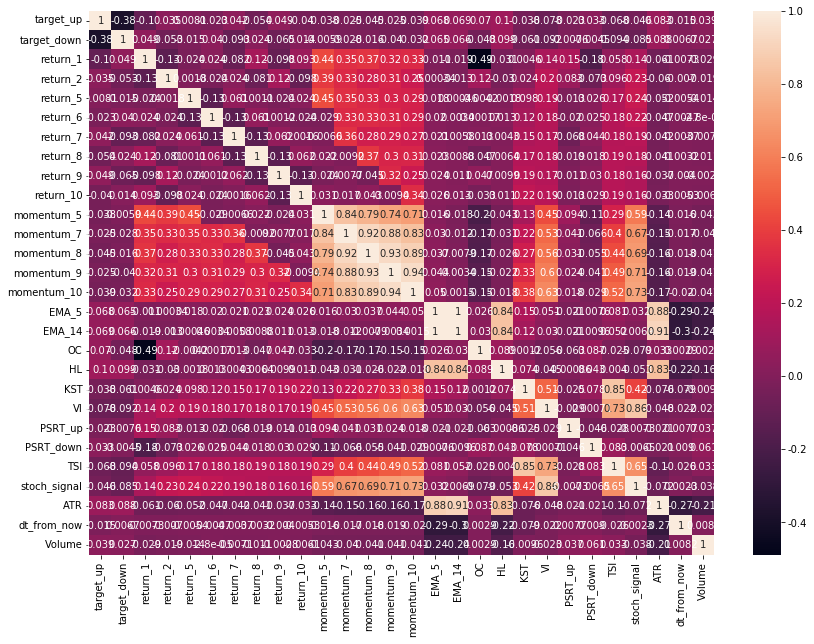

In [29]:
plt.figure(figsize=(14,10))
heatmap(corr, annot=True)

There are some variables that are highly correlated. Some of them are needed to be deleted to prevent multicollinearity.

# Fit LASSO & Ridge Models

In [30]:
model_df["dt"] = model_df["dt"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

## Split data

In [31]:
split_date = "2021-04-01"

model_data, oot_data = [], []
for stock in model_df["stockname"].unique():
    sub_data = model_df.loc[(model_df["stockname"] == stock)]
    model_data.append(sub_data[(sub_data["dt"] < split_date)])
    oot_data.append(sub_data[(sub_data["dt"] > split_date)])
model_data = pd.concat(model_data)
oot_data = pd.concat(oot_data)
print("model_df: {}  oot_df: {}".format(len(model_data), len(oot_data)))

model_df: 2620  oot_df: 156


#### Multicollinearity

In [32]:
vif_df = pd.DataFrame()
vif_df["Features"] = cols_pred
vif_df["VIF"] = [vif(model_data[cols_pred].values, i) for i in range(len(cols_pred))]
vif_df = vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)
while vif_df.loc[0, "VIF"] > 10:
    cols_pred.remove(vif_df.loc[0, "Features"])
    vif_df = vif_df.loc[1:]
    vif_df["VIF"] = [vif(model_data[cols_pred].values, i) for i in range(len(cols_pred))]
    vif_df = vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)
print(vif_df)

        Features       VIF
0       return_2  6.753982
1            ATR  5.451239
2             OC  5.356813
3      return_10  5.299466
4     momentum_8  4.757200
5      PSRT_down  4.150023
6       return_1  4.060886
7            TSI  2.204771
8            KST  1.576453
9             HL  1.492738
10  stoch_signal  1.442604
11    momentum_5  1.116456
12      return_8  1.094046
13       PSRT_up  1.064578


### <font color="red">Features used in prediction</font>

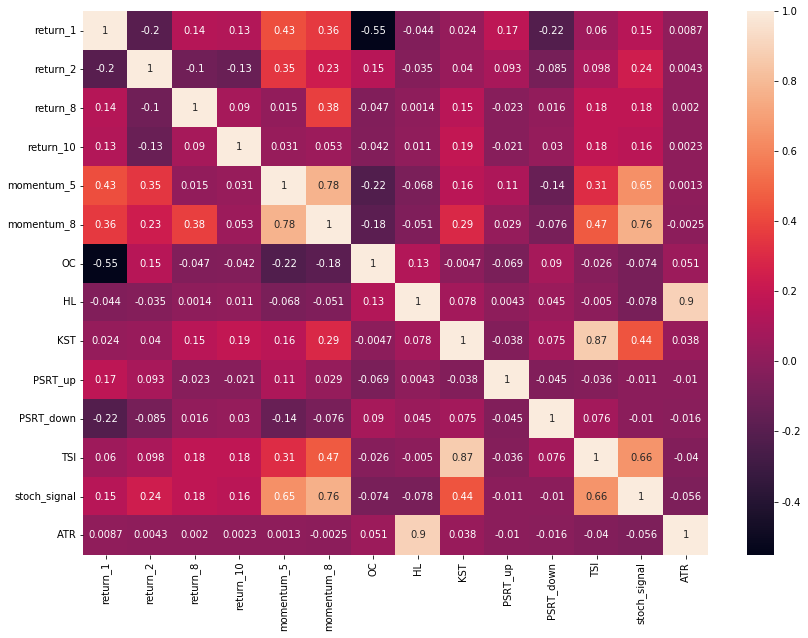

In [33]:
plt.figure(figsize=(14,10))
heatmap(model_data[cols_pred].corr(), annot=True)

In [34]:
cols_pred.remove("HL")
display(cols_pred)
print("# of features: {}".format(len(cols_pred)))

['return_1',
 'return_2',
 'return_8',
 'return_10',
 'momentum_5',
 'momentum_8',
 'OC',
 'KST',
 'PSRT_up',
 'PSRT_down',
 'TSI',
 'stoch_signal',
 'ATR']

# of features: 13


#### Train & Test Split

In [35]:
train_x, test_x, train_y1, test_y1 = train_test_split(model_data[cols_pred], model_data[col_target_up], train_size=0.7)
_, _, train_y2, test_y2 = train_test_split(model_data[cols_pred], model_data[col_target_down], train_size=0.7)

## LASSO

In [36]:
# Positive sign
lasso_pos = LassoCV(cv=10, random_state=1234)
lasso_pos.fit(train_x, train_y1)
lasso_coef_pos = pd.DataFrame({
    "Features": cols_pred,
    "Coef": lasso_pos.coef_
})
lasso_coef_pos.loc[len(lasso_coef_pos)] = ["intercept", lasso_pos.intercept_]
print("Up trend model:")
display(lasso_coef_pos[(lasso_coef_pos["Coef"] != 0)])

# Negative sign
lasso_neg = LassoCV(cv=10, random_state=1234)
lasso_neg.fit(train_x, train_y2)
lasso_coef_neg = pd.DataFrame({
    "Features": cols_pred,
    "Coef": lasso_neg.coef_
})
lasso_coef_neg.loc[len(lasso_coef_neg)] = ["intercept", lasso_neg.intercept_]
print("Down trend model:")
display(lasso_coef_neg[(lasso_coef_neg["Coef"] != 0)])

Up trend model:


,Features,Coef
0,return_1,-0.045542
1,return_2,0.009632
2,return_8,-0.016819
3,return_10,-0.012208
8,PSRT_up,-0.002360
9,PSRT_down,0.003169
10,TSI,-0.008074
12,ATR,0.045276
13,intercept,0.311028


Down trend model:


,Features,Coef
13,intercept,0.242771


## Ridge

In [37]:
# Positive sign
ridge_pos = RidgeCV(cv=10)
ridge_pos.fit(train_x, train_y1)
ridge_coef_pos = pd.DataFrame({
    "Features": cols_pred,
    "Coef": ridge_pos.coef_
})
ridge_coef_pos.loc[len(ridge_coef_pos)] = ["intercept", ridge_pos.intercept_]
print("Up trend model:")
display(ridge_coef_pos[(ridge_coef_pos["Coef"] != 0)])

# Negative sign
ridge_neg = RidgeCV(cv=10)
ridge_neg.fit(train_x, train_y2)
ridge_coef_neg = pd.DataFrame({
    "Features": cols_pred,
    "Coef": ridge_neg.coef_
})
ridge_coef_neg.loc[len(ridge_coef_neg)] = ["intercept", ridge_neg.intercept_]
print("Down trend model:")
display(ridge_coef_neg[(ridge_coef_neg["Coef"] != 0)])

Up trend model:


,Features,Coef
0,return_1,-0.044004
1,return_2,0.016214
2,return_8,-0.029738
3,return_10,-0.019824
4,momentum_5,-0.013846
5,momentum_8,0.016921
6,OC,0.003900
7,KST,0.042449
8,PSRT_up,-0.009930
9,PSRT_down,0.010787


Down trend model:


,Features,Coef
0,return_1,-0.017670
1,return_2,0.000795
2,return_8,-0.013366
3,return_10,0.003322
4,momentum_5,0.006305
5,momentum_8,0.000724
6,OC,-0.008496
7,KST,0.040175
8,PSRT_up,-0.002302
9,PSRT_down,0.000204


### Compare the Two Regression Coefficients

In [38]:
comp_pos_coef = pd.merge(ridge_coef_pos, lasso_coef_pos, on="Features", how="left")
comp_neg_coef = pd.merge(ridge_coef_neg, lasso_coef_neg, on="Features", how="left")
comp_pos_coef.columns = ["Features", "Ridge", "Lasso"]
comp_neg_coef.columns = ["Features", "Ridge", "Lasso"]
print("Up trend:")
display(comp_pos_coef)
print("Down trend:")
display(comp_neg_coef)

Up trend:


,Features,Ridge,Lasso
0,return_1,-0.044004,-0.045542
1,return_2,0.016214,0.009632
2,return_8,-0.029738,-0.016819
3,return_10,-0.019824,-0.012208
4,momentum_5,-0.013846,-0.000000
5,momentum_8,0.016921,0.000000
6,OC,0.003900,0.000000
7,KST,0.042449,0.000000
8,PSRT_up,-0.009930,-0.002360
9,PSRT_down,0.010787,0.003169


Down trend:


,Features,Ridge,Lasso
0,return_1,-0.017670,-0.000000
1,return_2,0.000795,0.000000
2,return_8,-0.013366,-0.000000
3,return_10,0.003322,0.000000
4,momentum_5,0.006305,0.000000
5,momentum_8,0.000724,-0.000000
6,OC,-0.008496,-0.000000
7,KST,0.040175,0.000000
8,PSRT_up,-0.002302,-0.000000
9,PSRT_down,0.000204,0.000000


## High Bias & Low Variance

Yes, L1 or L2 regression re more likely to have high bias and low variance.
Intuitively, the L1 and L2 regression include punishment items to prevent the estimation from overfitting the training data via affecting the coefficients on each predictor.
Mathematically, L1 and L2 punish the coefficients of the regression models by adding in terms of each parameter, so that the input data points will have different values in the parameters estimation process.
- For Lasso regression, it adds **absolute value of magnitude** of coefficent as penalty term to the loss function, which is represented as: $\sum^n_{i=1}(Y_i-\sum^p_{j=1}X_{ij}\beta_j)^2+\lambda\sum^{p}_{j=1}|\beta_j|$
<br>Expanding the formula, it will be quite obvious that, if we want to get the optimal value for the parameter $\beta_j$, we need to let the partial derivative equal to zero. For the absolute value function, it is not differentiable on the zero point. However, it reaches the minimum point there. That is how to can lead to zero optimal estimated parameters on L1 regularization.
- For Ridge regression, it adds **squared magnitude** of coefficent as penalty term to the loss function, which is represented as: $\sum^n_{i=1}(y_i-\sum^p_{j=1}x_{ij}\beta_j)^2+\lambda\sum^p_{j=1}\beta^2_j$
<br>Expanding the formula, it is a quadratic equation. To get the optimal value of $\beta_j$, we need to use partial derivatives. For quadratic function, it is not necessarily to reach the optimal point with zero $\beta_j$. However, since the add in of $\lambda$ will make the coefficient on the quadratic term larger. According to the solutions for for a quadratic equation, the quadratic item is the only coefficient on the denominator. Thus, the solution we get, which is exactly $\beta_j$ will be smaller than without regulariation.

## Logistic Sigmoid

#### Top Three coefficient

In [39]:
lasso_coef_pos["rank"] = lasso_coef_pos["Coef"].apply(lambda x: np.abs(x))
lasso_coef_pos = lasso_coef_pos.sort_values(by="rank", ascending=False)
lasso_coef_neg["rank"] = lasso_coef_neg["Coef"].apply(lambda x: np.abs(x))
lasso_coef_neg = lasso_coef_neg.sort_values(by="rank", ascending=False)
display(lasso_coef_pos[["Features", "Coef"]].head(4))
display(lasso_coef_neg[["Features", "Coef"]].head(4))
lasso_pos_cols = list(lasso_coef_pos["Features"])[:4]
lasso_neg_cols = list(lasso_coef_neg["Features"])[:4]
lasso_pos_cols.remove("intercept")
lasso_neg_cols.remove("intercept")
print(lasso_pos_cols)
print(lasso_neg_cols)

,Features,Coef
13,intercept,0.311028
0,return_1,-0.045542
12,ATR,0.045276
2,return_8,-0.016819


,Features,Coef
13,intercept,0.242771
0,return_1,-0.000000
1,return_2,0.000000
2,return_8,-0.000000


['return_1', 'ATR', 'return_8']
['return_1', 'return_2', 'return_8']


In [40]:
ridge_coef_pos["rank"] = ridge_coef_pos["Coef"].apply(lambda x: np.abs(x))
ridge_coef_pos = ridge_coef_pos.sort_values(by="rank", ascending=False)
ridge_coef_neg["rank"] = ridge_coef_neg["Coef"].apply(lambda x: np.abs(x))
ridge_coef_neg = ridge_coef_neg.sort_values(by="rank", ascending=False)
display(ridge_coef_pos[["Features", "Coef"]].head(4))
display(ridge_coef_neg[["Features", "Coef"]].head(4))
ridge_pos_cols = list(ridge_coef_pos["Features"])[:4]
ridge_neg_cols = list(ridge_coef_neg["Features"])[:4]
ridge_pos_cols.remove("intercept")
ridge_neg_cols.remove("intercept")
print(ridge_pos_cols)
print(ridge_neg_cols)

,Features,Coef
13,intercept,0.310215
10,TSI,-0.059852
12,ATR,0.048296
0,return_1,-0.044004


,Features,Coef
13,intercept,0.242274
10,TSI,-0.043529
7,KST,0.040175
0,return_1,-0.017670


['TSI', 'ATR', 'return_1']
['TSI', 'KST', 'return_1']


In [41]:
train_df = pd.DataFrame(train_x, columns=cols_pred)
display(train_df.head(3))

,return_1,return_2,return_8,return_10,momentum_5,momentum_8,OC,KST,PSRT_up,PSRT_down,TSI,stoch_signal,ATR
590,0.491856,-0.057917,-0.236535,-0.213343,-0.937989,-0.685315,-0.189686,-0.335750,-0.213321,-0.214241,-0.662902,-1.615287,-0.026587
304,-0.403075,-0.077346,0.265947,0.569800,-0.000695,0.183204,0.131576,-0.785847,-0.213321,-0.214241,-0.694810,1.023050,-0.550774
350,-0.320527,0.210700,-0.535690,0.076891,-1.216699,-1.090265,0.141868,-0.314941,-0.213321,-0.214241,-0.965311,-1.442173,-0.561689


### LASSO

In [42]:
coef_pos_array, coef_neg_array = [], []
for col in cols_pred + ["intercept"]:
    coef_pos_array.append(lasso_coef_pos.loc[(lasso_coef_pos["Features"] == col), "Coef"].values[0])
    coef_neg_array.append(lasso_coef_neg.loc[(lasso_coef_neg["Features"] == col), "Coef"].values[0])
coef_pos_array = np.array(coef_pos_array).reshape(-1, 1)
coef_neg_array = np.array(coef_neg_array).reshape(-1, 1)
x = train_x.copy()
x["constant"] = 1
z_pos_lasso = np.dot(coef_pos_array.reshape(1, -1), x.T)
z_neg_lasso = np.dot(coef_neg_array.reshape(1, -1), x.T)

In [43]:
def graph_logistic_sigmoid(cols: list, z: np.array):
    for col in cols:
        print(col)
        x, y = np.array(train_df[col]), 1 / (1 + np.exp(-z))
        plt.scatter(x, y)
        plt.show()

return_1


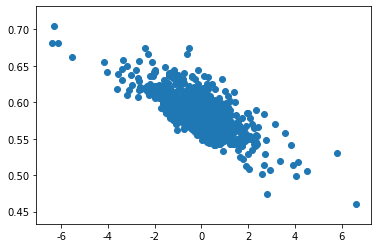

ATR


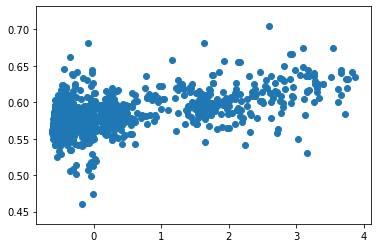

TSI


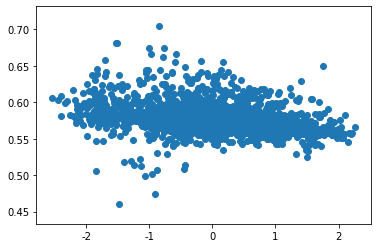

In [710]:
graph_logistic_sigmoid(lasso_pos_cols, z_pos_lasso)

PSRT_up


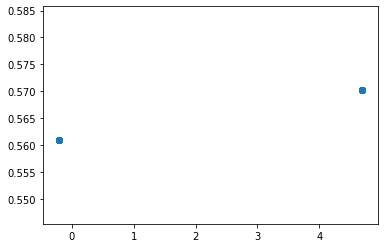

return_1


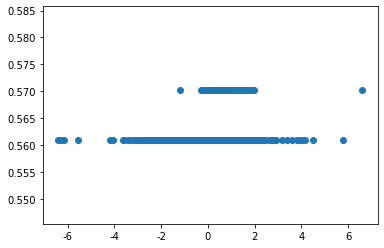

return_2


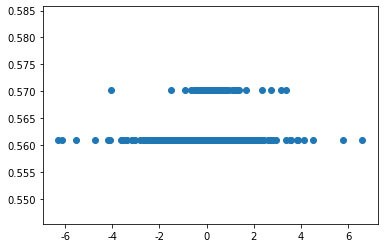

In [711]:
graph_logistic_sigmoid(lasso_neg_cols, z_neg_lasso)

### Ridge

In [712]:
coef_pos_array, coef_neg_array = [], []
for col in cols_pred + ["intercept"]:
    coef_pos_array.append(ridge_coef_pos.loc[(ridge_coef_pos["Features"] == col), "Coef"].values[0])
    coef_neg_array.append(ridge_coef_neg.loc[(ridge_coef_neg["Features"] == col), "Coef"].values[0])
coef_pos_array = np.array(coef_pos_array).reshape(-1, 1)
coef_neg_array = np.array(coef_neg_array).reshape(-1, 1)
x = train_x.copy()
x["constant"] = 1
z_pos_ridge = np.dot(coef_pos_array.reshape(1, -1), x.T)
z_neg_ridge = np.dot(coef_neg_array.reshape(1, -1), x.T)

TSI


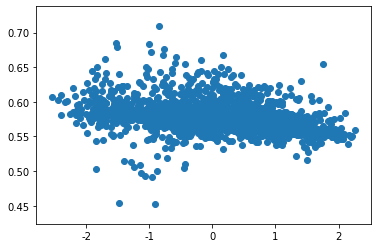

ATR


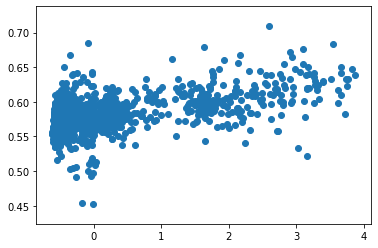

return_1


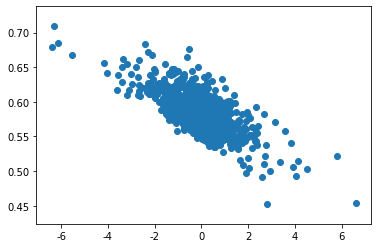

In [713]:
graph_logistic_sigmoid(ridge_pos_cols, z_pos_ridge)

momentum_8


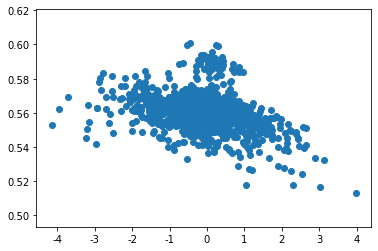

KST


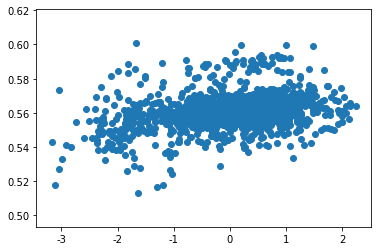

stoch_signal


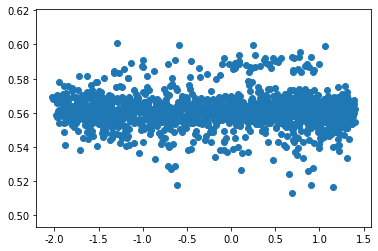

In [714]:
graph_logistic_sigmoid(ridge_neg_cols, z_neg_ridge)

## Feature Scoring / Elimenation

### 1. Dispersion ratio

The dispersion ratio applies the arithmetic mean (AM) and the geometric mean (GM) to calculate the ratio between these two values. It is calculated by using the following function:

$$
RM_i=\frac{\frac{1}{n}\sum^n_{j=1}X_{ij}}{(\prod^n_{j=1}X_{ij})^{\frac{1}{n}}}=\frac{AM_i}{GM_i}\in[1, +\infty]
$$

$AM_i\geqslant GM_i$ and the equality only hold when $X_{i1}=X_{i2}=\cdots=X_{in}$.

The dispersion ratio shows the information provided by the variable. The higher the ratio, the more relevant the feature it is. When all the features have the same value, the feature provides no information at all.

The mathematic rationale behind is that, for the products of numbers within a range with the same mean, they reaches the largest when they are the same or close to each other, otherwise, the product of them will be small. Thus, if the values of one feature differs a lot, then the products of them will become smaller with the same mean. For the numbers with the same product, the larger the variance, the larger the mean. Thus, if the values of one feature differs a lot, then the mean of the feature tend to be larger.
<br>The dispersion ratio uses this mathematical property to select features with larger variance, which can provide more information.

In [715]:
def feature_selection_DR(df: pd.DataFrame, predictors: list):
    x = np.array(df[predictors]) + 1
    am = np.mean(x, axis=0)
    gm = np.power(np.prod(np.abs(x), axis=0), 1 / x.shape[0])
    rm = am / gm
    plt.figure(figsize=(12,8))
    plt.bar(predictors, rm, color='teal')
    plt.xticks(rotation=45)
    plt.title("Dispersion Ratio")
    DR_df = pd.DataFrame({
        "Features": predictors,
        "Dispersion ratio": rm
    })
    return DR_df

,Features,Dispersion ratio
0,ATR,1.317521
1,TSI,1.181401
2,PSRT_down,1.171667
3,PSRT_up,1.155451
4,return_10,1.154350
5,stoch_signal,1.150155
6,return_2,1.142692
7,return_1,1.126666
8,return_8,1.126261
9,momentum_5,1.122029


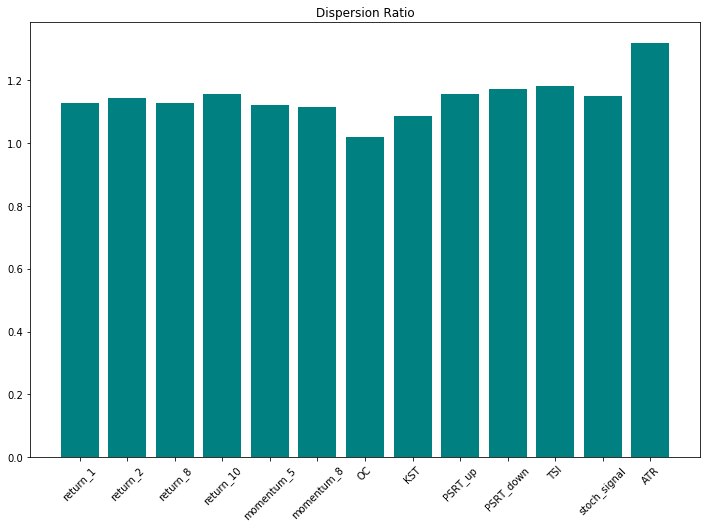

In [716]:
DR = feature_selection_DR(train_x, cols_pred)
DR = DR.sort_values(by="Dispersion ratio", ascending=False).reset_index(drop=True)
display(DR)

### Plot first 3 winning features

#### Lasso

- Positive target

ATR


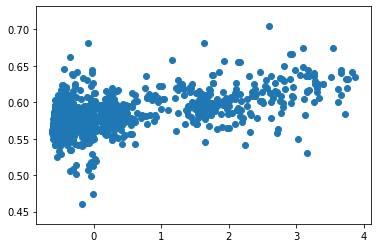

TSI


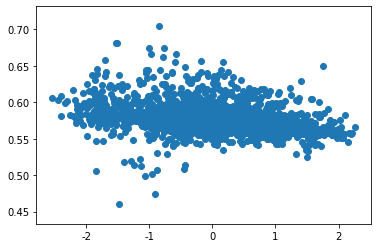

PSRT_down


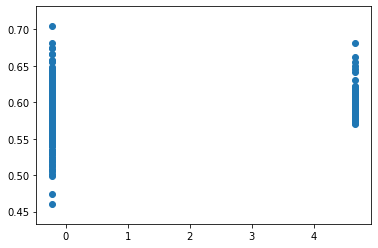

In [717]:
graph_logistic_sigmoid(list(DR.loc[:2, "Features"]), z_pos_lasso)

- Negative target

ATR


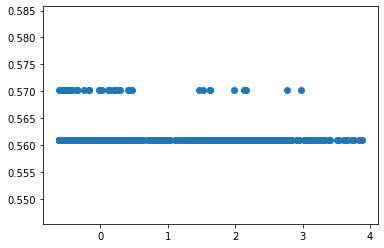

TSI


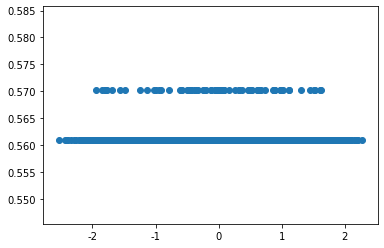

PSRT_down


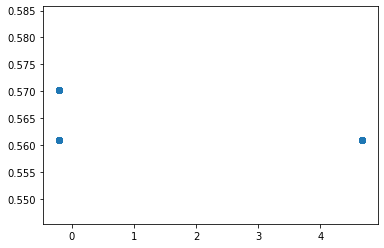

In [718]:
graph_logistic_sigmoid(list(DR.loc[:2, "Features"]), z_neg_lasso)

#### Ridge

- Positive target

ATR


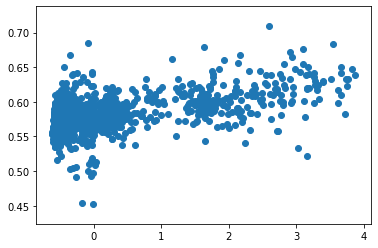

TSI


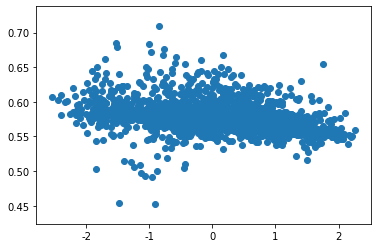

PSRT_down


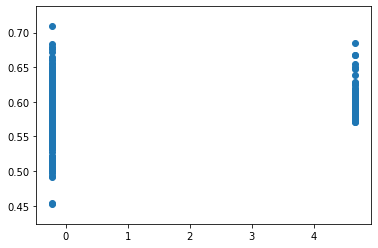

In [719]:
graph_logistic_sigmoid(list(DR.loc[:2, "Features"]), z_pos_ridge)

- Negative target

ATR


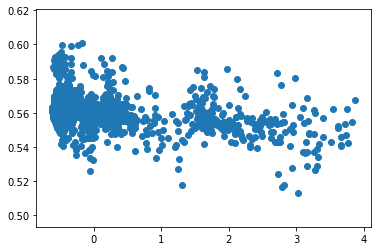

TSI


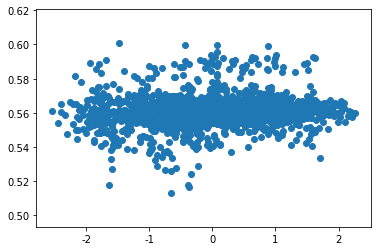

PSRT_down


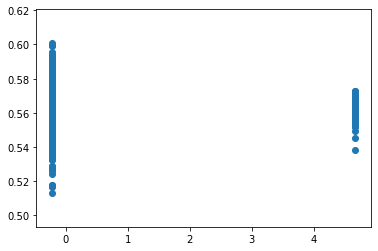

In [720]:
graph_logistic_sigmoid(list(DR.loc[:2, "Features"]), z_neg_ridge)

### 2. SelectKBest

SelectKBest is a feature selection method to decise the best number of k features according to a given function.
<br>For the linear regression problem here, I am going to use the f_regression as the given function in SelectKBest features.

f_regression is a linear model to test the prediction power of the features towards the target. It calculates the correlation between each feature and the target according to the mathematics formula shown below.

$$
\frac{(x_{ij}-E(x_i)(y_j-E(y))}{\sigma_{x_i}\sigma_y}
$$

Then it converts the score to F-statistic value, and p value to decide whether the feature has prediction power to the target.

In [721]:
from sklearn.feature_selection import SelectKBest, f_regression
np.set_printoptions(suppress=True)
pd.set_option("display.float_format", lambda x: '%.6f'%x)

skb_pos = SelectKBest(f_regression, k=3).fit(train_x, train_y1)
skb_neg = SelectKBest(f_regression, k=3).fit(train_x, train_y2)
pos_skb_df = pd.DataFrame({
    "Features": cols_pred,
    "F_stats": skb_pos.scores_,
    "p_values": skb_pos.pvalues_
})
neg_skb_df = pd.DataFrame({
    "Features": cols_pred,
    "F_stats": skb_neg.scores_,
    "p_values": skb_neg.pvalues_
})
print("Positive target:")
display(pos_skb_df)
pos_skb_cols = [i for e, i in enumerate(cols_pred) if skb_pos.get_support()[e]]
print(pos_skb_cols)
print("\nNegative target:")
display(neg_skb_df)
neg_skb_cols = [i for e, i in enumerate(cols_pred) if skb_neg.get_support()[e]]
print(neg_skb_cols)

Positive target:


,Features,F_stats,p_values
0,return_1,36.271221,0.000000
1,return_2,2.764719,0.096535
2,return_8,10.058799,0.001541
3,return_10,11.151339,0.000857
4,momentum_5,9.375280,0.002231
5,momentum_8,13.183228,0.000290
6,OC,12.646714,0.000386
7,KST,1.747513,0.186355
8,PSRT_up,3.405993,0.065121
9,PSRT_down,2.843618,0.091908


['return_1', 'momentum_8', 'ATR']

Negative target:


,Features,F_stats,p_values
0,return_1,0.546006,0.460049
1,return_2,0.754625,0.385130
2,return_8,0.787312,0.375031
3,return_10,0.340787,0.559447
4,momentum_5,0.097477,0.754914
5,momentum_8,1.370690,0.241846
6,OC,0.106121,0.744641
7,KST,1.276071,0.258779
8,PSRT_up,4.561708,0.032827
9,PSRT_down,0.019277,0.889591


['momentum_8', 'PSRT_up', 'ATR']


### Plot the first 3 winning features

#### Lasso

- Positive target

return_1


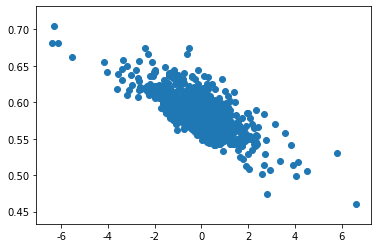

momentum_8


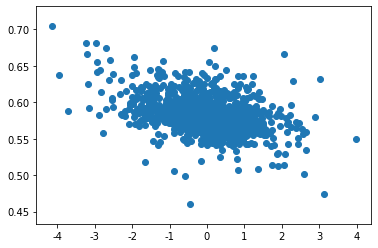

ATR


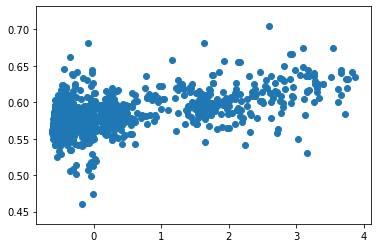

In [722]:
graph_logistic_sigmoid(pos_skb_cols, z_pos_lasso)

- Negative target

momentum_8


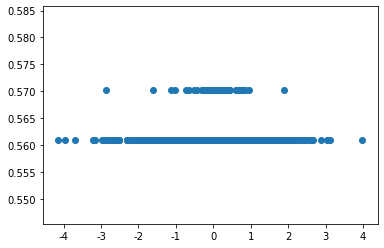

PSRT_up


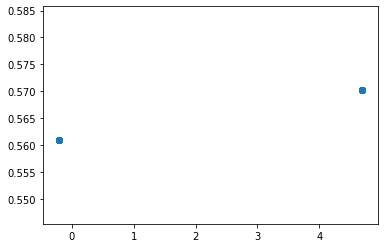

ATR


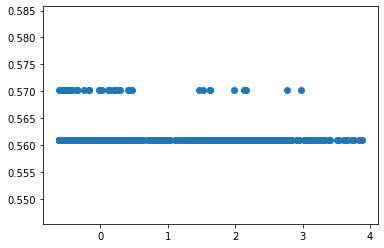

In [723]:
graph_logistic_sigmoid(neg_skb_cols, z_neg_lasso)

#### Ridge

- Positive target

return_1


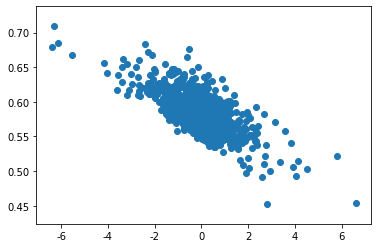

momentum_8


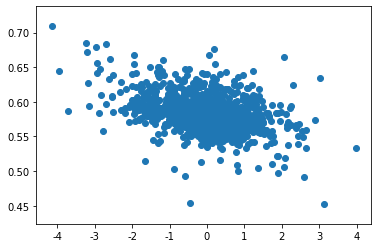

ATR


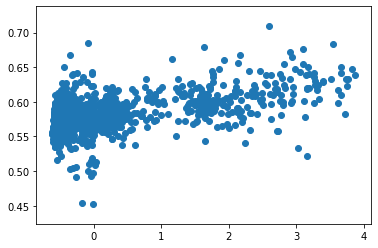

In [724]:
graph_logistic_sigmoid(pos_skb_cols, z_pos_ridge)

- Negative target

momentum_8


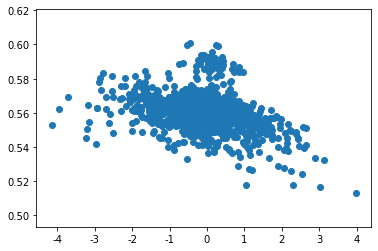

PSRT_up


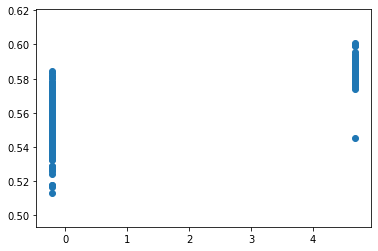

ATR


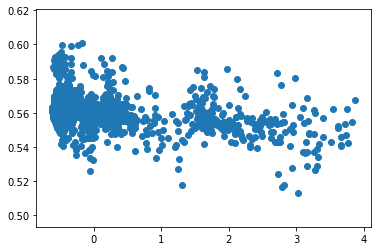

In [725]:
graph_logistic_sigmoid(neg_skb_cols, z_neg_ridge)

## Prediction Model

In [773]:
cols_pred_pos = ["return_1", "ATR", "TSI"]#, "PSRT_down", "momentum_8"]
cols_pred_neg = ["PSRT_up", "momentum_8"]#, "KST", "ATR", "stoch_signal", "TSI", "PSRT_down"]

In [774]:
display(train_x.columns)
x_arr1, x_arr2 = np.array(train_x[cols_pred_pos]), np.array(train_x[cols_pred_neg])
lr_pos = Logit(np.array(train_y1), np.hstack([x_arr1, np.ones(x_arr1.shape[0]).reshape(-1, 1)]))
res_pos = lr_pos.fit()

# lr_neg = Logit(np.array(train_y2), np.hstack([x_arr2, np.ones(x_arr2.shape[0]).reshape(-1, 1)]))
lr_neg = Logit(np.array(train_y2), x_arr2)
res_neg = lr_neg.fit()

Index(['return_1', 'return_2', 'return_8', 'return_10', 'momentum_5',
       'momentum_8', 'OC', 'KST', 'PSRT_up', 'PSRT_down', 'TSI',
       'stoch_signal', 'ATR'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.605503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690956
         Iterations 4


In [775]:
res_pos.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.027     
Dependent Variable: y                AIC:              2227.7748 
Date:               2021-11-23 16:48 BIC:              2249.8296 
No. Observations:   1833             Log-Likelihood:   -1109.9   
Df Model:           3                LL-Null:          -1140.2   
Df Residuals:       1829             LLR p-value:      4.4513e-13
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.3185     0.0591    -5.3919   0.0000   -0.4342   -0.2027
x2        0.2352     0.0534     4.4068   0.0000    0.1306    0.3398
x3       -0.1133     0.0530    -2.1371   0.0326   -0.2171   -0.0094
const    -0.7950     0.0515   -15.4524   0.0000   -0.8959   -0.6942
=================================================================

"""

In [776]:
res_neg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: -0.237   
Dependent Variable: y                AIC:              2537.0460
Date:               2021-11-23 16:48 BIC:              2548.0734
No. Observations:   1833             Log-Likelihood:   -1266.5  
Df Model:           1                LL-Null:          -1023.8  
Df Residuals:       1831             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025    0.975]
-------------------------------------------------------------------
x1     0.1095      0.0499     2.1931    0.0283     0.0116    0.2073
x2    -0.0993      0.0556    -1.7846    0.0743    -0.2083    0.0098
================================================================

"""

## Evalution

### ROC curve

In [800]:
def graph_roc_curve(y_test: np.array, y_hat: np.array, target_name:str):
    fpr, tpr, _ = roc_curve(np.array(y_test), y_hat)
    auc_val = auc(fpr, tpr)
    
    fig = plt.figure(figsize=(12, 9))
    plt.plot(fpr, tpr, color="sandybrown", label="ROC curve (area=%.3f)" % auc_val)
    plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="darkblue", alpha=0.7, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve of {} Target".format(target_name))
    plt.legend()
    plt.show()

In [797]:
hat_y1 = res_pos.predict(np.hstack([np.array(test_x[cols_pred_pos]), np.ones(len(test_x)).reshape(-1, 1)]))
hat_y2 = res_neg.predict(np.array(test_x[cols_pred_neg]))

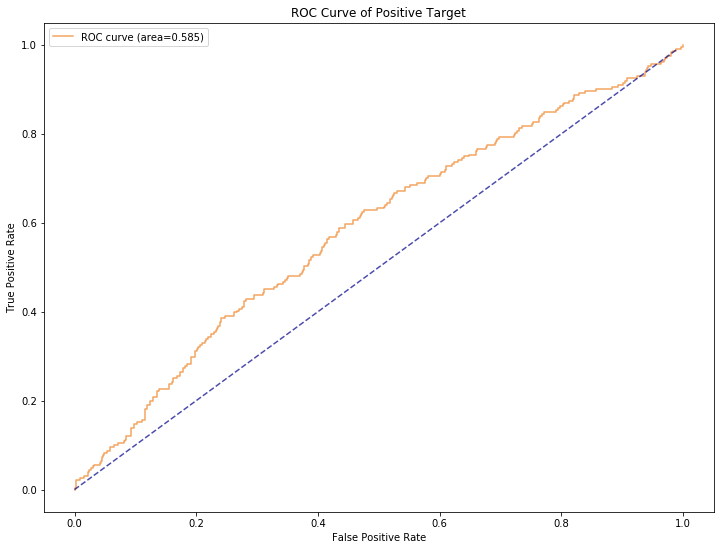

In [798]:
graph_roc_curve(np.array(test_y1), hat_y1, "Positive")

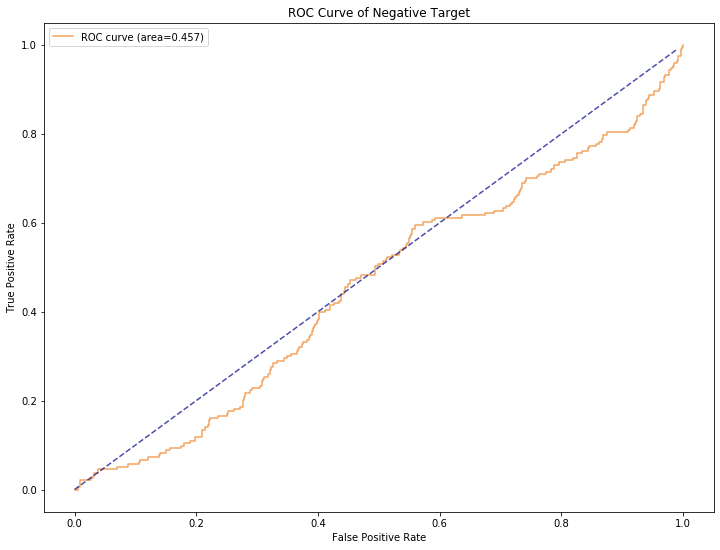

In [799]:
graph_roc_curve(np.array(test_y2), hat_y2, "Negative")

## Confusion Matrix

In [845]:
def graph_KS_curve(true_val: np.array, hat_val: np.array, title: str):
    x, true_val = np.arange(0, 1.05, 0.05), np.array(true_val).reshape(-1, 1)
    class0, class1 = [], []
    for i in x:
        y = hat_val < i
        target = np.array(true_val)[y]
        if target.shape[0] == 0:
            class0.append(0)
            class1.append(0)
            continue
        class0.append((target.shape[0] - sum(target)) / target.shape[0])
        class1.append(sum(target) / target.shape[0])
    fig = plt.figure(figsize=(12, 6))
    plt.plot(x, class1, color="sandybrown", label="Class1")
    plt.plot(x, class0, color="mediumseagreen", label="Class0")
    plt.xticks(rotation=45)
    plt.legend()
    plt.title("KS Curve: {}".format(title))
    plt.show()

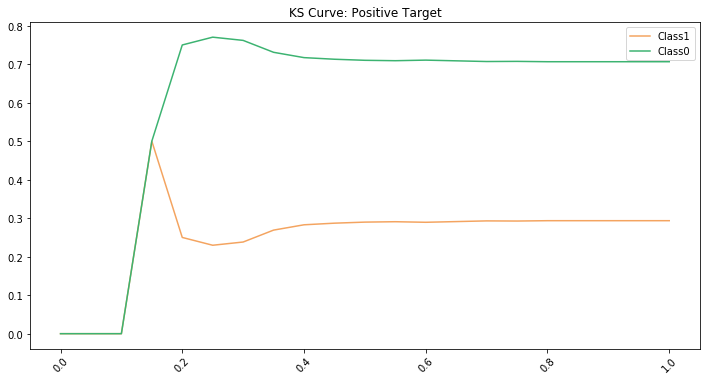

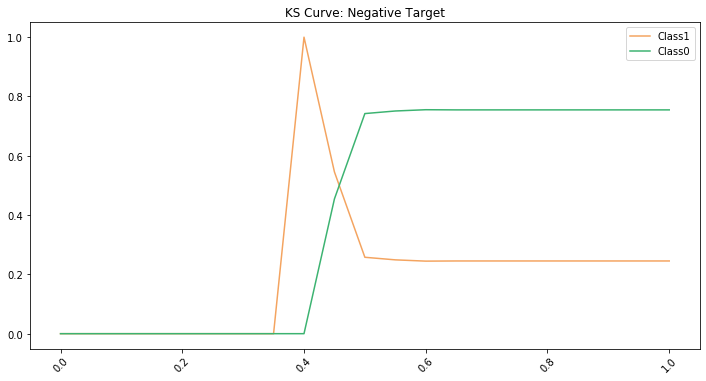

In [853]:
graph_KS_curve(test_y1, hat_y1, "Positive Target")
graph_KS_curve(test_y2, hat_y2, "Negative Target")

### Recall
$$
Recall=\frac{TP}{TP+FN}
$$
### Precision
$$
Precision=\frac{TP}{TP+FP}
$$

### On test data

In [898]:
print("Original positive rate:")
print("  positive target: {:.3f}  negative target: {:.3f}".format(
    sum(test_y1) / len(test_y1), sum(test_y2) / len(test_y2)
))
res_y1, res_y2 = (hat_y1 > 0.25) * 1, (hat_y2 > 0.45) * 1
pos_conf_mtx = confusion_matrix(test_y1, res_y1)
print("Positive Target confusion matrix:")
display(pos_conf_mtx)
print("F1 score:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\n".format(
    f1_score(test_y1, res_y1), precision_score(test_y1, res_y1), recall_score(test_y1, res_y1)))

neg_conf_mtx = confusion_matrix(test_y2, res_y2)
print("Negative Target confusion matrix:")
display(neg_conf_mtx)
print("F1 score:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}".format(
    f1_score(test_y2, res_y2), precision_score(test_y2, res_y2), recall_score(test_y2, res_y2)))

Original positive rate:
  positive target: 0.294  negative target: 0.245
Positive Target confusion matrix:


array([[114, 442],
       [ 34, 197]])

F1 score:0.453
Precision:0.308
Recall:0.853

Negative Target confusion matrix:


array([[  5, 589],
       [  6, 187]])

F1 score:0.386
Precision:0.241
Recall:0.969


### On OOT data

In [899]:
oot_hat_y1 = res_pos.predict(np.hstack([np.array(oot_data[cols_pred_pos]), np.ones(len(oot_data)).reshape(-1, 1)]))
oot_hat_y2 = res_neg.predict(np.array(oot_data[cols_pred_neg]))

oot_res_y1, oot_res_y2 = (oot_hat_y1 > 0.25) * 1, (oot_hat_y2 > 0.45) * 1
pos_conf_mtx = confusion_matrix(oot_data[col_target_up], oot_res_y1)
print("Positive Target confusion matrix:")
display(pos_conf_mtx)
print("F1 score:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\n".format(
    f1_score(oot_data[col_target_up], oot_res_y1), precision_score(oot_data[col_target_up], oot_res_y1), 
    recall_score(oot_data[col_target_up], oot_res_y1)))

neg_conf_mtx = confusion_matrix(oot_data[col_target_down], oot_res_y2)
print("Negative Target confusion matrix:")
display(neg_conf_mtx)
print("F1 score:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}".format(
    f1_score(oot_data[col_target_down], oot_res_y2), precision_score(oot_data[col_target_down], oot_res_y2), 
    recall_score(oot_data[col_target_down], oot_res_y2)))

Positive Target confusion matrix:


array([[  8, 107],
       [  1,  40]])

F1 score:0.426
Precision:0.272
Recall:0.976

Negative Target confusion matrix:


array([[  2, 113],
       [  3,  38]])

F1 score:0.396
Precision:0.252
Recall:0.927


## Scatter Plots of Up & Down Moves

In [895]:
def graph_scatter_real_hat(true_val: np.array, hat_val: np.array, threshold: float, title=None):
    df = pd.DataFrame({
        "y": true_val,
        "hat": hat_val
    })
    df["hat_cls"] = (df["hat"] > threshold) * 1
    df_0, df_1 = df.loc[(df["y"] == 0)], df.loc[(df["y"] == 1)]
    
    plt.figure(figsize=(12, 3))
    plt.scatter(df_1.loc[(df_1["hat_cls"] == 1), "hat"], df_1.loc[(df_1["hat_cls"] == 1), "y"] + 0.01, 
                color="sandybrown", alpha=0.5, label="Correctly classified to 1")
    plt.scatter(df_1.loc[(df_1["hat_cls"] == 0), "hat"], df_1.loc[(df_1["hat_cls"] == 0), "y"] - 0.01, 
                color="cornflowerblue", alpha=0.5, marker="*", label="Falsely classified to 0")
    plt.scatter(df_0.loc[(df_0["hat_cls"] == 0), "hat"], df_0.loc[(df_0["hat_cls"] == 0), "y"] + 0.01, 
                color="orangered", alpha=0.5, label="Correctly classified to 0")
    plt.scatter(df_0.loc[(df_0["hat_cls"] == 1), "hat"], df_0.loc[(df_0["hat_cls"] == 1), "y"] - 0.01, 
                color="mediumseagreen", alpha=0.5, marker="*", label="Falsely classified to 1")
    plt.legend()
    plt.title("Scatter Plot {}".format(title))
    plt.show()

## On Test Data

### Up Move

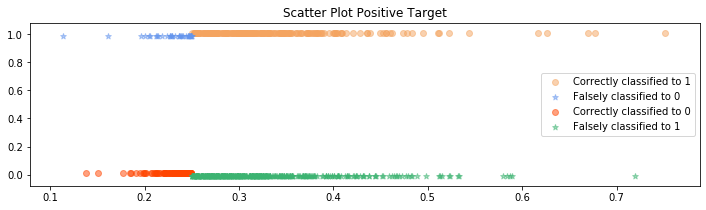

In [896]:
graph_scatter_real_hat(test_y1, hat_y1, threshold=0.25, title="Positive Target")

### Down Move

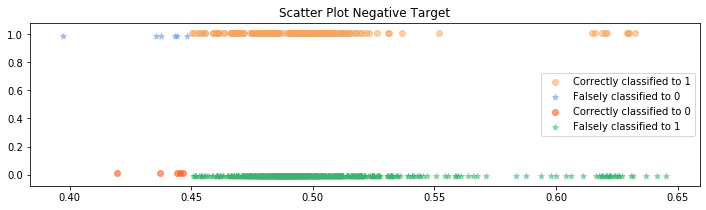

In [897]:
graph_scatter_real_hat(test_y2, hat_y2, threshold=0.45, title="Negative Target")

## On OOT Data

### Up Move

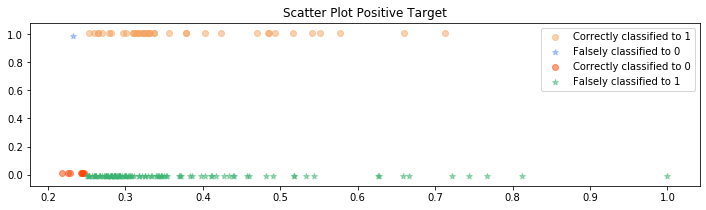

In [901]:
graph_scatter_real_hat(oot_data[col_target_up], oot_hat_y1, threshold=0.25, title="Positive Target")

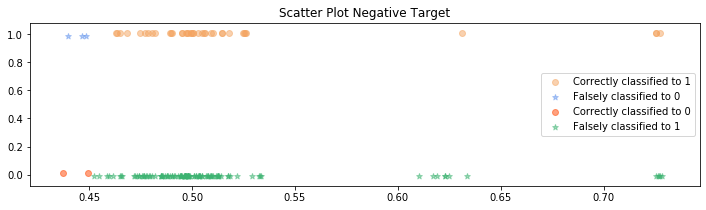

In [902]:
graph_scatter_real_hat(oot_data[col_target_down], oot_hat_y2, threshold=0.45, title="Negative Target")